In [141]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2
import slug
import os
import numpy as np
import matplotlib.pyplot as plt
from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP
from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
def run_intermediate_sample(num, z_set, filename, img_path):
    prefix = 'HSC-mid-' + str(num)
    img = fits.open(img_path + filename[num])[1]
    w = wcs.WCS(img)
    display_single(img.data)
    plt.show(block=False)
    # phys_size
    redshift = z_set[num]['z_best']
    phys_size = slug.phys_size(redshift)
    # extract_obj
    data = img.data.byteswap().newbyteorder()
    objects, segmap = slug.extract_obj(
        data,
        b=30,
        f=5,
        sigma=5,
        pixel_scale=slug.HSC_pixel_scale,
        deblend_cont=0.1,
        deblend_nthresh=20,
        show_fig=False)
    # make mask
    seg_mask = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
    # evaluate_sky
    bkg_global = slug.evaluate_sky(data, show_fig=False, show_hist=False)
    # Save image and mask
    if not os.path.isdir('Images'):
        os.mkdir('Images')
    if not os.path.isdir('Masks'):
        os.mkdir('Masks')
    if not os.path.isdir('MaskedImg'):
        os.mkdir('MaskedImg')
    img_fits = './Images/' + prefix + '_img.fits'
    msk_fits = './Masks/' + prefix + '_msk.fits'
    
    io.save_to_fits(data, img_fits, wcs=w)
    io.save_to_fits(seg_mask.astype('uint8'), msk_fits, wcs=w)
    io.save_to_fits(data*(~seg_mask), './MaskedImg/MaskedImg' + prefix + '.fits', wcs=w)
    
    display_single(data*(~seg_mask))
    plt.show(block=False)
    # Run ELLIPSE
    %%time
    iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
    ell_free, ell_fix = slug.run_SBP(
        img_fits,
        msk_fits,
        slug.HSC_pixel_scale,
        phys_size,
        iraf_path,
        step=0.1,
        n_clip=3,
        low_clip=3.0,
        upp_clip=2.5,
        outPre=prefix)

In [68]:
img_path = './Cutout/z_0203/'

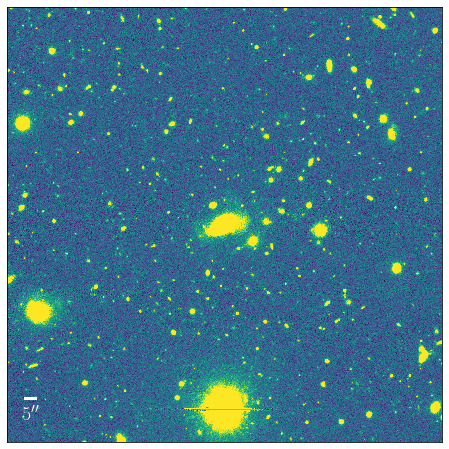

At redshift 0.21077999472618103 , 1 arcsec = 3.43727086624 kpc
# Detect 336 objects
# Mean Sky / RMS Sky =    0.00019 /    0.04224


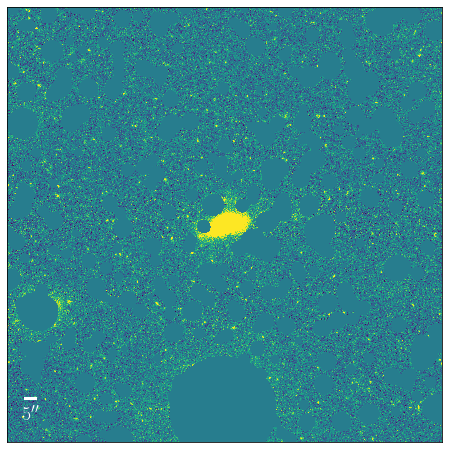

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 5.96 µs
./Masks/HSC-mid-40_msk.fits -> temp_KJ0ZC.fits.pl
./Masks/HSC-mid-40_msk.fits -> temp_KJ0ZC.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  595 595
###      galR :  20.0
###      iniSma, maxSma :  10.0 900.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./Images/HSC-mid-40_img.fits
###      Input Image   : temp_KJ0ZC.fits
###      Output Binary : ./Images/HSC-mid-40_img_ellip_2.bin
---------------------------------------------------------------

In [77]:
%%time
from IPython.display import clear_output
for num in range(40,41):
    clear_output()
    run_intermediate_sample(num, z_0203, filename, img_path)

At redshift 0.295109987259 , 1 arcsec = 4.40378210091 kpc


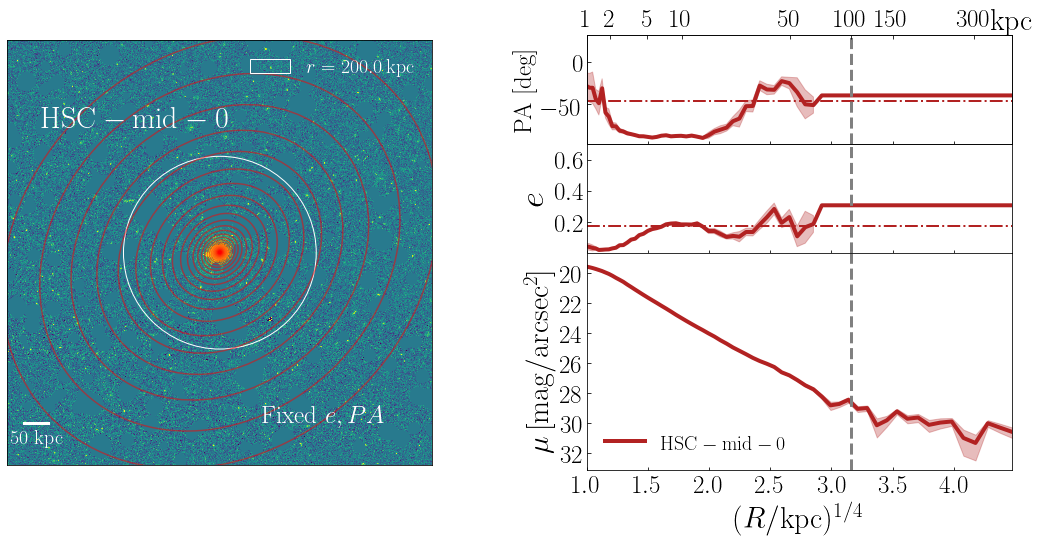

In [28]:
num = 0
prefix = 'HSC-mid-' + str(num)
HSC_ellipse_fix = Table.read('./Data/' + prefix + '-ellip-3.csv', format='csv')
HSC_ellipse_free = Table.read('./Data/' + prefix + '-ellip-2.csv', format='csv')
seg_mask = fits.open('./Masks/HSC-mid-0_msk.fits')[0].data.astype(bool)
img_corr = fits.open('./Images/HSC-mid-0_img.fits')[0].data
img_masked = (~seg_mask)*img_corr

fig = plt.figure(figsize=(18, 8))
grid = plt.GridSpec(4, 9, wspace=0.5, hspace=0.0)

ax4 = fig.add_subplot(grid[0:4, 0:4])
ax4 = slug.display_isophote(
    img_masked,
    HSC_ellipse_fix,
    slug.HSC_pixel_scale,
    text=prefix,
    ax=ax4,
    contrast=0.2,
    circle=200,
    physical_scale=4.40378210091)

cen = img_masked.shape[0]/2
ax4.text(cen * 1.2, cen * 0.2, r'$\mathrm{Fixed}\ e, PA$', color='w', fontsize=25)

ax3 = fig.add_subplot(grid[0, 5:9])
ax2 = fig.add_subplot(grid[1, 5:9])
ax1 = fig.add_subplot(grid[2:, 5:9])
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')
ax3.tick_params(direction='in')

ax1, ax2, ax3 = slug.SBP_shape(
    HSC_ellipse_free,
    HSC_ellipse_fix,
    0.29510998725891113,
    slug.HSC_pixel_scale,
    slug.HSC_zeropoint,
    ax=[ax1, ax2, ax3],
    physical_unit=True,
    x_max=(400**0.25),
    vertical_line=True,
    show_dots=False,
    linecolor='firebrick',
    label=prefix)
#ax1.invert_yaxis()
#plt.savefig('./Figures/HSC_binary_mask.png', bbox_inches='tight', dpi=250)

At redshift 0.295109987259 , 1 arcsec = 4.40378210091 kpc


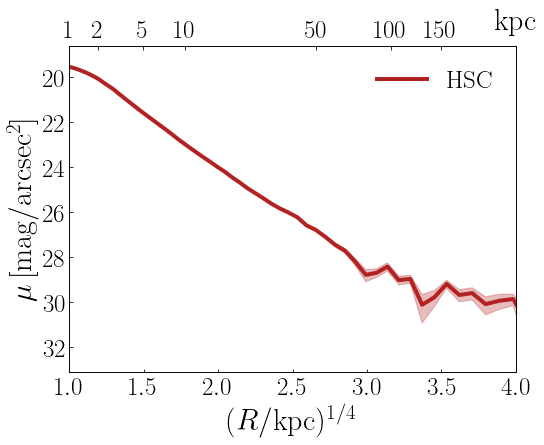

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = slug.SBP_single(
    HSC_ellipse_fix,
    0.29510998725891113,
    slug.HSC_pixel_scale,
    slug.HSC_zeropoint,
    label='HSC',
    vertical_line=False,
    physical_unit=True,
    ax=ax,
    x_min=1,
    x_max=4)

/anaconda3/envs/iraf27/lib/python2.7/site-packages/slug-0.1-py2.7.egg/slug/__init__.py:661: RuntimeWarning: invalid value encountered in log10
  y_lower = -2.5*np.log10((ell_fix['intens']-ell_fix['int_err'])/(pixel_scale)**2)+zeropoint
/anaconda3/envs/iraf27/lib/python2.7/site-packages/slug-0.1-py2.7.egg/slug/__init__.py:659: RuntimeWarning: invalid value encountered in log10
  y = -2.5*np.log10(ell_fix['intens'].data/(pixel_scale)**2)+zeropoint
/anaconda3/envs/iraf27/lib/python2.7/site-packages/slug-0.1-py2.7.egg/slug/__init__.py:660: RuntimeWarning: invalid value encountered in log10
  y_upper = -2.5*np.log10((ell_fix['intens']+ell_fix['int_err'])/(pixel_scale)**2)+zeropoint


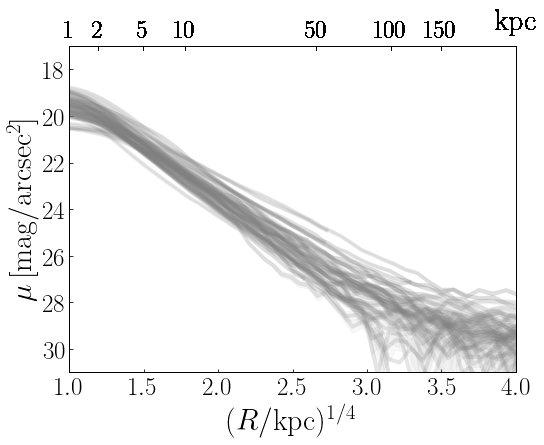

In [126]:
fig, ax = plt.subplots(figsize=(8, 6))

for num in range(0, 49):
    prefix = 'HSC-mid-' + str(num)
    ell_fix = Table.read('./Data/' + prefix + '-ellip-3.csv', format='csv')
    slug.SBP_single(ell_fix,
                   z_0203[num]['z_best'],
                   slug.HSC_pixel_scale,
                   slug.HSC_zeropoint,
                   physical_unit=True,
                   label=None,
                   ax=ax, linecolor='gray', x_min=1, alpha=0.2)
plt.ylim(17, 31)
ax.invert_yaxis()
#plt.savefig('./50stack.png', dpi=200, bbox_inches='tight')

## Let's test the mock one

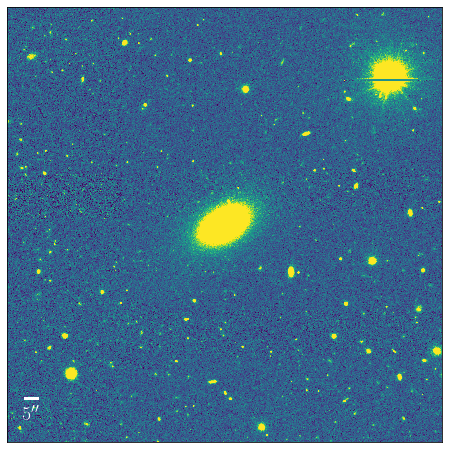

In [129]:
prefix = 'mock-test'
img = fits.open('../MockTest/easy/img_mock_n4.fits')[0]
w = wcs.WCS(fits.open('../MockTest/easy/field.fits')[0])
_ = display_single(img.data)

# Detect 594 objects
# Mean Sky / RMS Sky =    0.00146 /    0.06151


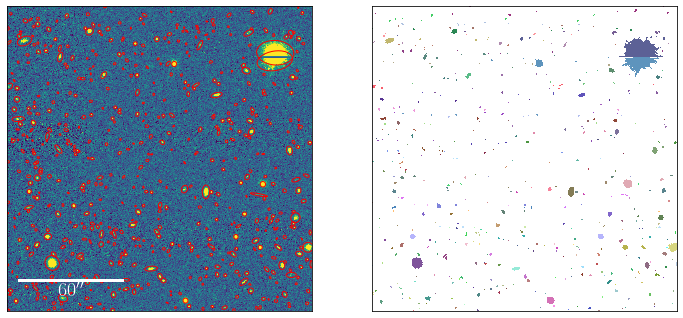

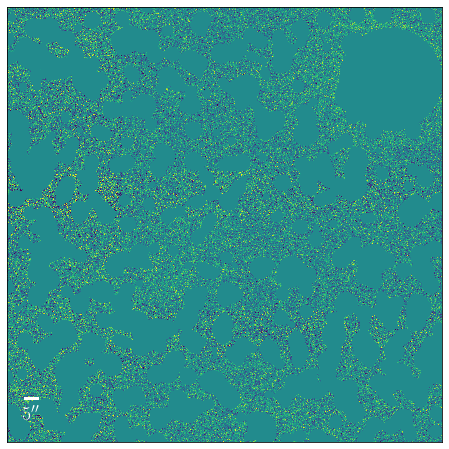

In [148]:
field = fits.open('../MockTest/easy/field.fits')[0]
w = wcs.WCS(field)
data = field.data.byteswap().newbyteorder()
objects, segmap = slug.extract_obj(
    data,
    b=30,
    f=5,
    sigma=1.5,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1,
    deblend_nthresh=20
)
seg_mask = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
# evaluate_sky
bkg_global = slug.evaluate_sky(data, show_fig=False, show_hist=False)
display_single(data*(~seg_mask))
plt.show(block=False)

# Detect 631 objects
# Mean Sky / RMS Sky =    0.00107 /    0.06159


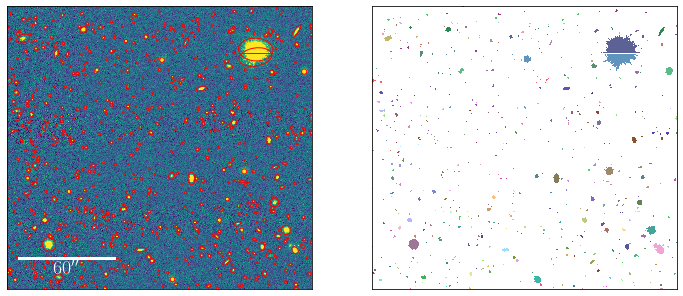

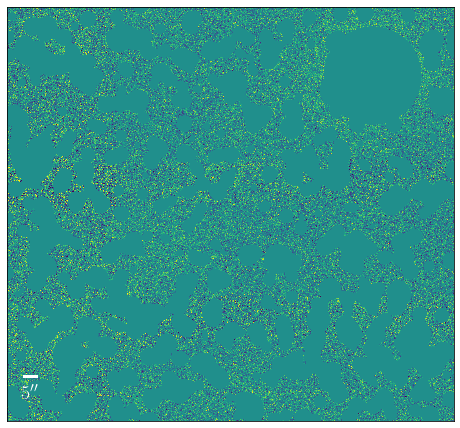

In [150]:
field = fits.open('../MockTest/easy/field-s16a.fits')[0]
w = wcs.WCS(field)
data = field.data.byteswap().newbyteorder()
objects, segmap = slug.extract_obj(
    data,
    b=30,
    f=5,
    sigma=1.5,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1,
    deblend_nthresh=20
)
seg_mask = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
# evaluate_sky
bkg_global = slug.evaluate_sky(data, show_fig=False, show_hist=False)
display_single(data*(~seg_mask))
plt.show(block=False)

In [130]:
# phys_size
redshift = 0.05
print(redshift)
phys_size = slug.phys_size(redshift)

0.05
At redshift 0.05 , 1 arcsec = 0.97749363834 kpc


# Detect 114 objects


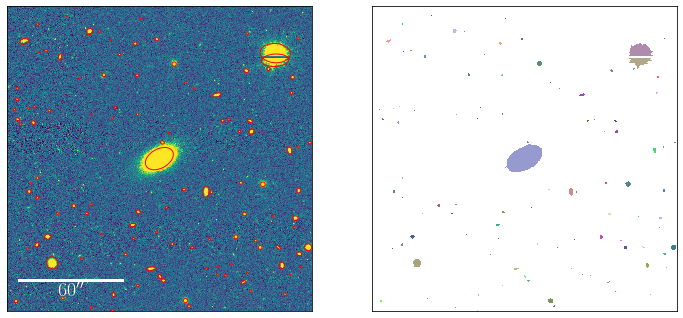

In [131]:
# extract_obj
data = img.data.byteswap().newbyteorder()
objects, segmap = slug.extract_obj(
    data,
    b=30,
    f=5,
    sigma=6,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1,
    deblend_nthresh=20
)

# Mean Sky / RMS Sky =    0.00204 /    0.06226


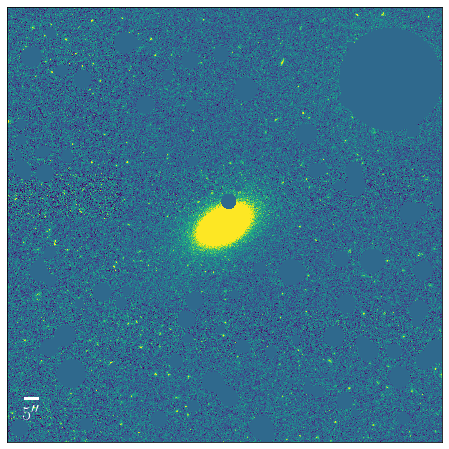

./MoMo/mock-test_msk.fits -> temp_UAWW0.fits.pl
./MoMo/mock-test_msk.fits -> temp_UAWW0.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  528 528
###      galR :  20.0
###      iniSma, maxSma :  10.0 900.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./MoMo/mock-test_img.fits
###      Input Image   : temp_UAWW0.fits
###      Output Binary : ./MoMo/mock-test_img_ellip_2.bin
----------------------------------------------------------------------------------------------------
###     Input background value   :  

In [136]:
seg_mask = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
# evaluate_sky
bkg_global = slug.evaluate_sky(data, show_fig=False, show_hist=False)
# Save image and mask
if not os.path.isdir('MoMo'):
    os.mkdir('MoMo')
img_fits = './MoMo/' + prefix + '_img.fits'
msk_fits = './MoMo/' + prefix + '_msk.fits'

io.save_to_fits(data, img_fits, wcs=w)
io.save_to_fits(seg_mask.astype('uint8'), msk_fits, wcs=w)
io.save_to_fits(data*(~seg_mask), './MoMo/' + prefix + '.fits', wcs=w)

display_single(data*(~seg_mask))
plt.show(block=False)
# Run ELLIPSE
iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
ell_free, ell_fix = slug.run_SBP(
    img_fits,
    msk_fits,
    slug.HSC_pixel_scale,
    phys_size,
    iraf_path,
    step=0.1,
    n_clip=3,
    low_clip=3.0,
    upp_clip=2.5,
    outPre=prefix)

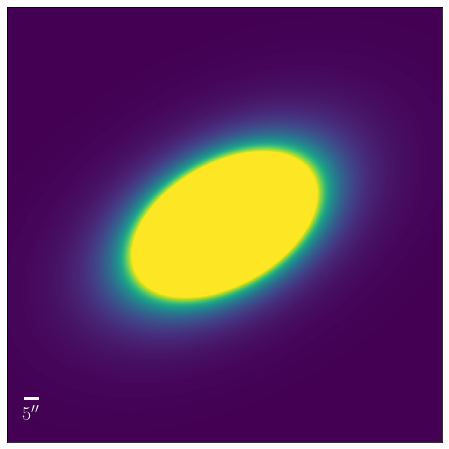

In [84]:
prefix = 'model-test'
img = fits.open('../MockTest/easy/img_model_n4.fits')[0]
w = wcs.WCS(fits.open('../MockTest/easy/field.fits')[0])
_ = display_single(img.data)

In [85]:
# phys_size
redshift = 0.05
print(redshift)
phys_size = slug.phys_size(redshift)

0.05
At redshift 0.05 , 1 arcsec = 0.97749363834 kpc


# Detect 1 objects


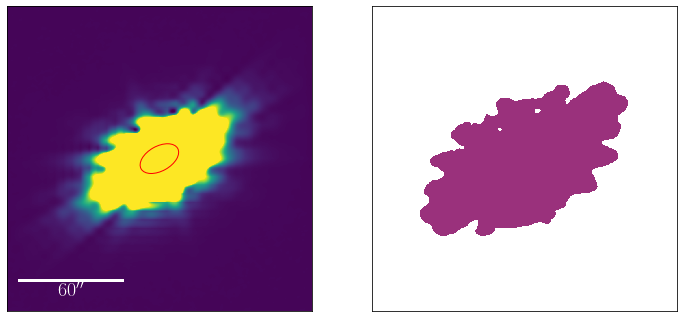

In [93]:
# extract_obj
data = img.data.byteswap().newbyteorder()
objects, segmap = slug.extract_obj(
    data,
    b=30,
    f=5,
    sigma=6,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1,
    deblend_nthresh=20
)

In [94]:
# Save image and mask
if not os.path.isdir('MoMo'):
    os.mkdir('MoMo')
img_fits = './MoMo/' + prefix + '_img.fits'

io.save_to_fits(data, img_fits, wcs=w)

# Run ELLIPSE
iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
ell_free, ell_fix = slug.run_SBP(
    img_fits,
    None,
    slug.HSC_pixel_scale,
    phys_size,
    iraf_path,
    step=0.1,
    n_clip=3,
    low_clip=3.0,
    upp_clip=2.5,
    outPre=prefix)

----------------------------------------------------------------------------------------------------
###      galX, galY :  528 528
###      galR :  20.0
###      iniSma, maxSma :  10.0 900.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./MoMo/model-test_img.fits
###      Input Image   : temp_X0011.fits
###      Output Binary : ./MoMo/model-test_img_ellip_2.bin
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  0.0
###     Current outer background :  0.0


mea

Let's see whether our pipeline is good

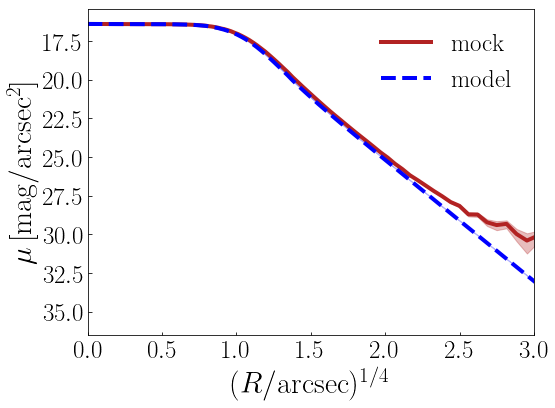

In [137]:
mock_fix = Table.read('./Data/mock-test-ellip-3.csv', format='csv')
model_fix = Table.read('./Data/model-test-ellip-3.csv', format='csv')
fig, ax = plt.subplots(figsize=(8, 6))
slug.SBP_single(mock_fix,
               0.05,
               slug.HSC_pixel_scale,
               slug.HSC_zeropoint,
               label='mock',
               physical_unit=False,
               ax=ax, linecolor='firebrick', x_min=0)
slug.SBP_single(model_fix,
               0.05,
               slug.HSC_pixel_scale,
               slug.HSC_zeropoint,
               label='model',
               physical_unit=False,
               ax=ax, linecolor='blue', linestyle='--', x_min=0, x_max=3)
ax.invert_yaxis()
plt.savefig('mock_test_not_subtracted.png', dpi=200, bbox_inches='tight')